In [32]:
# Instala o scikit-image para as métricas de avaliação (PSNR, SSIM)
!pip install scikit-image

import cv2
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import os
import tarfile
import requests
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow

In [33]:
def baixar_e_extrair_bsds(url, nome_arquivo):

    # O caminho para as imagens neste .tgz
    pasta_imagens = "BSDS300/images/train/"

    if os.path.exists(pasta_imagens):
        print(f"Dataset está baixado e extraído em {pasta_imagens}")
        return pasta_imagens

    print(f"Baixando dataset de {url}")
    try:
        print("Executando !wget...")
        !wget -q -O {nome_arquivo} {url}

        # Verifica se o wget realmente criou o arquivo
        if not os.path.exists(nome_arquivo):
            raise FileNotFoundError(f"wget falhou ao baixar {nome_arquivo}. Verifique o link e a conexão.")

        print(f"Arquivo salvo como {nome_arquivo}")

        # Extrai o arquivo .tgz
        print(f"Extraindo {nome_arquivo}...")
        with tarfile.open(nome_arquivo, "r:gz") as tar:
            tar.extractall()

        print("Dataset extraído com sucesso.")
        print(f"Imagens de treino estão em: {pasta_imagens}")
        return pasta_imagens

    except Exception as e:
        print(f"Erro ao baixar ou extrair: {e}")
        return None

url_bsds = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
nome_arquivo_tgz = "BSDS300-images.tgz"
pasta_treino_bsds = baixar_e_extrair_bsds(url_bsds, nome_arquivo_tgz)

Dataset está baixado e extraído em BSDS300/images/train/


In [34]:
def gerar_mascara_aleatoria(imagem, num_falhas=5, max_tam_falha=50):
    """
    Gera uma máscara booleana para simular partes faltantes.
    True = pixel ausente, False = pixel conhecido.
    """
    mascara = np.zeros(imagem.shape[:2], dtype=bool)
    altura, largura = mascara.shape

    for _ in range(num_falhas):
        tam_x = np.random.randint(10, max_tam_falha)
        tam_y = np.random.randint(10, max_tam_falha)

        x = np.random.randint(0, largura - tam_x)
        y = np.random.randint(0, altura - tam_y)

        mascara[y:y+tam_y, x:x+tam_x] = True

    return mascara

def calcular_metricas(original, restaurada):
    """
    Avalia o desempenho da restauração.
    Calcula PSNR e SSIM.
    """
    # PSNR (Peak Signal-to-Noise Ratio)
    # data_range=1.0 porque normalizámos as imagens para [0, 1]
    valor_psnr = psnr(original, restaurada, data_range=1.0)

    # SSIM (Structural Similarity Index)
    # O 'multichannel=True' é necessário para imagens RGB
    valor_ssim = ssim(original, restaurada, data_range=1.0, multichannel=True, channel_axis=-1)

    return valor_psnr, valor_ssim

In [35]:
def montar_sistema_poisson(img, mascara):
    """
    Monta o sistema linear esparso Ax=b.
    'img' é um canal 2D normalizado [0, 1].
    'mascara' é booleana (True = ausente).
    """

    altura, largura = img.shape

    # 1. Identificar pixels ausentes
    pixels_ausentes = np.where(mascara)
    N = len(pixels_ausentes[0]) # N é o número total de incógnitas

    # Mapeia coordenadas (i, j) para o índice k (0 a N-1) do sistema linear
    mapa_pixels = np.full(img.shape, -1, dtype=int)
    mapa_pixels[pixels_ausentes] = np.arange(N)

    # 2. Montar Matriz A (N x N) e Vetor b (N x 1)
    A = sp.lil_matrix((N, N)) # Matriz A [cite: 140]
    b = np.zeros(N)           # Vetor b [cite: 141]

    for k in range(N):
        i, j = pixels_ausentes[0][k], pixels_ausentes[1][k]

        # Define a diagonal principal (o '-4' da eq. do Laplaciano)
        A[k, k] = -4

        # Analisa os 4 vizinhos
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            viz_i, viz_j = i + di, j + dj

            # Se o vizinho está DENTRO da máscara (é outra incógnita 'm')
            if mascara[viz_i, viz_j]:
                viz_k = mapa_pixels[viz_i, viz_j]
                A[k, viz_k] = 1

            # Se o vizinho está FORA da máscara (é uma borda conhecida)
            else:
                # O valor conhecido passa para o lado direito (vetor b)
                b[k] -= img[viz_i, viz_j]

    # Converte A para o formato CSR para um cálculo rápido
    A_csr = A.tocsr()
    return A_csr, b, mapa_pixels

def resolver_sistema_lu(A, b):
    """
    Resolve o sistema Ax=b usando decomposição LU esparsa.
    """

    # splu (Sparse LU) decompõe A = LU
    lu_obj = spla.splu(A.tocsc())

    print("Resolvendo para x (Ly=b e Ux=y)")
    x = lu_obj.solve(b)

    print("Sistema resolvido.")
    return x

def reconstruir_imagem(img, mascara, x):
    """
    Preenche a imagem com a solução 'x'.
    """
    img_restaurada = img.copy()
    pixels_ausentes = np.where(mascara)

    # Preenche os locais da máscara com os valores calculados de x
    img_restaurada[pixels_ausentes] = x

    # Garante que os valores permaneçam no intervalo válido [0, 1]
    img_restaurada = np.clip(img_restaurada, 0, 1)

    return img_restaurada

In [36]:
def processar_canal(canal_img, canal_mascara):
    """Orquestra o processo todo para um único canal (tons de cinza)"""

    # Passo A: Montando sistema Poisson
    A, b, mapa_pixels = montar_sistema_poisson(canal_img, canal_mascara)

    # Passo B: Resolvendo com Decomposição LU
    x = resolver_sistema_lu(A, b)

    # Passo C: Reconstruindo canal
    canal_restaurado = reconstruir_imagem(canal_img, canal_mascara, x)

    return canal_restaurado

def restaurar_imagem_colorida(img_colorida, mascara):
    """
    Restaura uma imagem colorida (RGB) processando cada canal separadamente.
    """

    b, g, r = cv2.split(img_colorida)

    # PROCESSANDO CANAL VERMELHO (R)
    r_restaurado = processar_canal(r, mascara)

    # PROCESSANDO CANAL VERDE (G)
    g_restaurado = processar_canal(g, mascara)

    # PROCESSANDO CANAL AZUL (B)
    b_restaurado = processar_canal(b, mascara)

    # Junta os canais restaurados
    img_final_restaurada = cv2.merge([b_restaurado, g_restaurado, r_restaurado])

    return img_final_restaurada

Imagens de teste selecionadas: ['140055.jpg', '27059.jpg', '207056.jpg']
Processando imagem: 140055.jpg
Gerando máscara aleatória
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.

 Avaliando Resultados:
Avaliação Quantitativa para 140055.jpg:
  PSNR: 35.67 dB
  SSIM: 0.9705

 Vizualizando os Resultados:


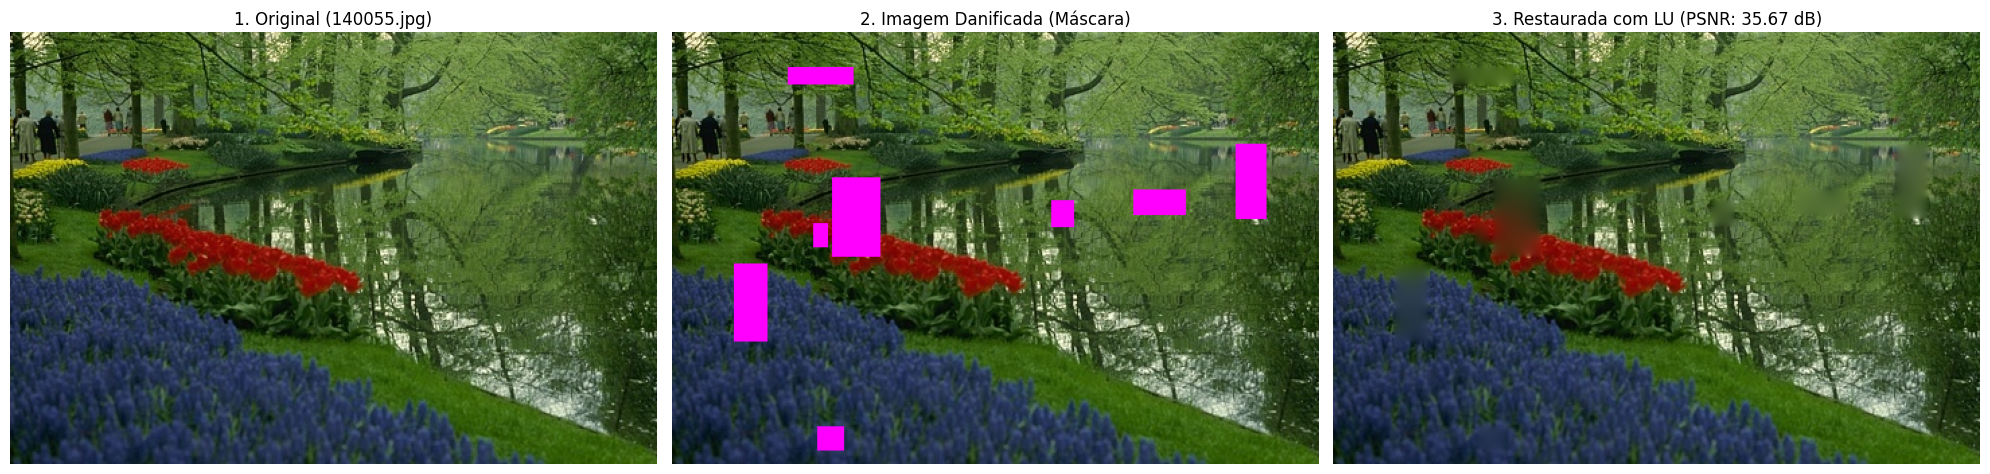

Processando imagem: 27059.jpg
Gerando máscara aleatória
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.

 Avaliando Resultados:
Avaliação Quantitativa para 27059.jpg:
  PSNR: 29.54 dB
  SSIM: 0.9644

 Vizualizando os Resultados:


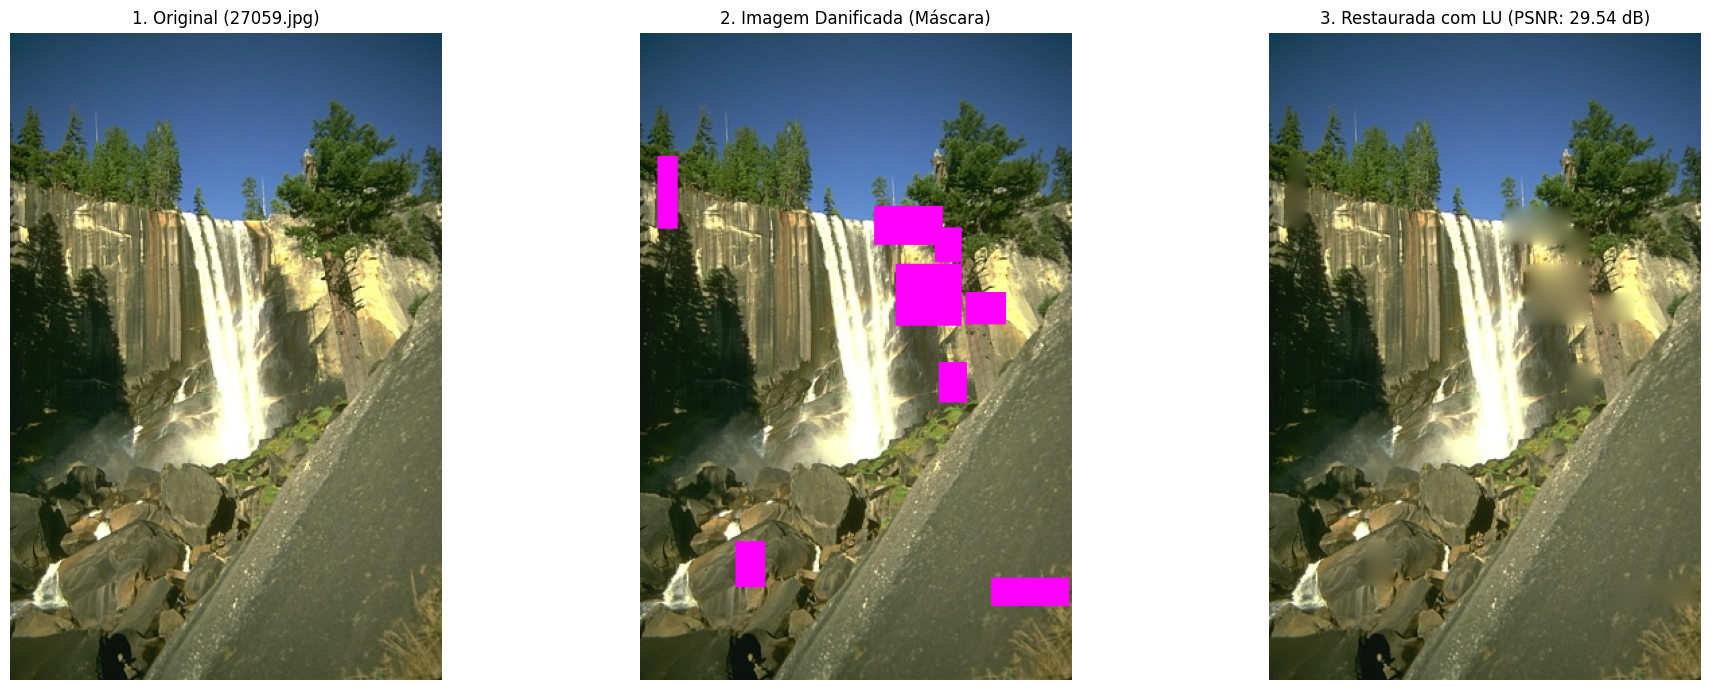

Processando imagem: 207056.jpg
Gerando máscara aleatória
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.
Resolvendo para x (Ly=b e Ux=y)
Sistema resolvido.

 Avaliando Resultados:
Avaliação Quantitativa para 207056.jpg:
  PSNR: 35.77 dB
  SSIM: 0.9639

 Vizualizando os Resultados:


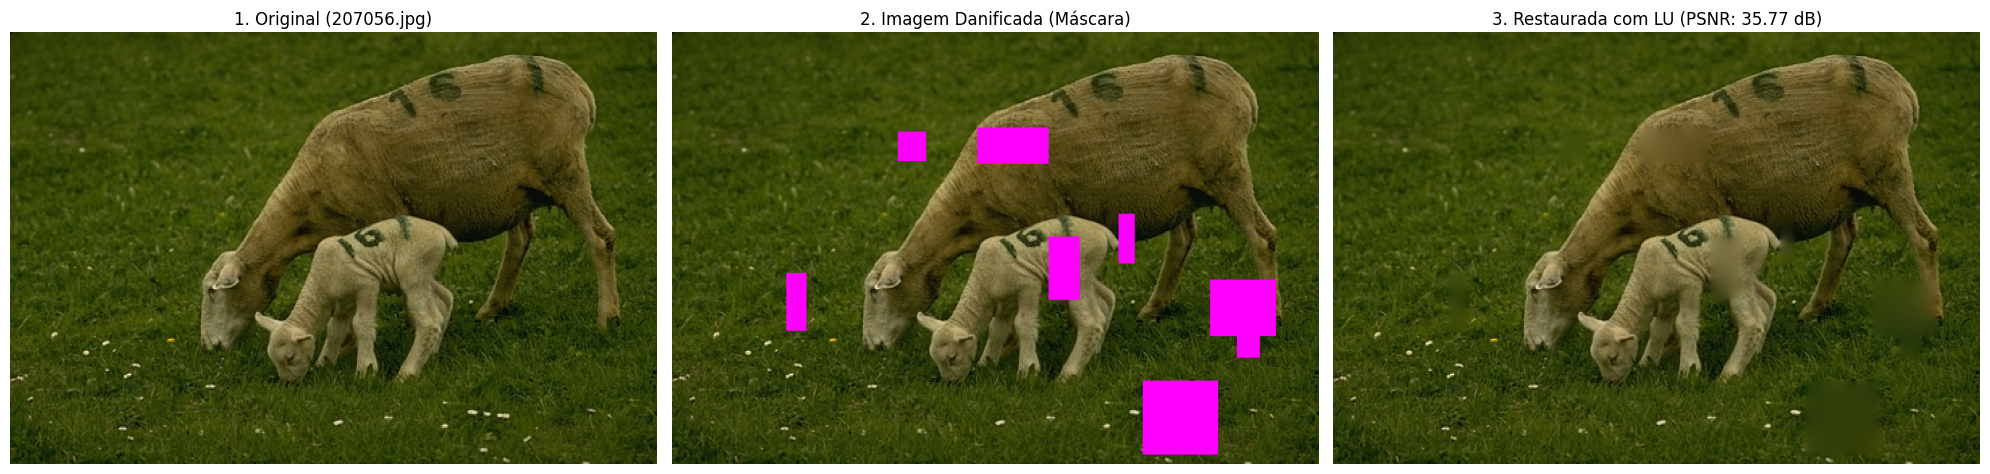

In [39]:
try:
    if pasta_treino_bsds and os.path.exists(pasta_treino_bsds):

        # Lista todos os ficheiros na pasta de treino
        try:
            todos_ficheiros = os.listdir(pasta_treino_bsds)
            ficheiros_jpg = [f for f in todos_ficheiros if f.lower().endswith('.jpg')]

            if not ficheiros_jpg:
                raise FileNotFoundError("Nenhum ficheiro .jpg encontrado na pasta de treino.")

            imagens_para_testar = ficheiros_jpg[:3]
            print(f"Imagens de teste selecionadas: {imagens_para_testar}")

        except Exception as e_lista:
            print(f"Erro ao listar ficheiros em {pasta_treino_bsds}: {e_lista}")
            raise

        for nome_img_teste in imagens_para_testar:
            print(f"Processando imagem: {nome_img_teste}")

            caminho_img_teste = os.path.join(pasta_treino_bsds, nome_img_teste)

            img_original_rgb = cv2.imread(caminho_img_teste)
            if img_original_rgb is None:
                print(f"Aviso: Não foi possível ler a imagem {caminho_img_teste}. A saltar.")
                continue # Pula para a próxima imagem

            # Normaliza para [0, 1] para os cálculos
            img_original_rgb = img_original_rgb.astype(float) / 255.0

            # Gerar Máscara
            print("Gerando máscara aleatória")
            mascara_bin = gerar_mascara_aleatoria(img_original_rgb, num_falhas=8, max_tam_falha=60)

            # Criar Imagem Danificada
            img_danificada_rgb = img_original_rgb.copy()
            img_danificada_rgb[mascara_bin] = [1, 0, 1] # [B, G, R] -> [R, B] = Magenta

            # Executar Restauração
            img_restaurada_rgb = restaurar_imagem_colorida(img_original_rgb, mascara_bin)

            # Avaliação
            print("\n Avaliando Resultados:")
            img_restaurada_rgb = np.nan_to_num(img_restaurada_rgb)

            valor_psnr, valor_ssim = calcular_metricas(img_original_rgb, img_restaurada_rgb)

            print(f"Avaliação Quantitativa para {nome_img_teste}:")
            print(f"  PSNR: {valor_psnr:.2f} dB")
            print(f"  SSIM: {valor_ssim:.4f}")

            # Visualização Final
            print("\n Vizualizando os Resultados:")
            img_original_plt = cv2.cvtColor(img_original_rgb.astype(np.float32), cv2.COLOR_BGR2RGB)
            img_danificada_plt = cv2.cvtColor(img_danificada_rgb.astype(np.float32), cv2.COLOR_BGR2RGB)
            img_restaurada_plt = cv2.cvtColor(img_restaurada_rgb.astype(np.float32), cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(20, 7))

            plt.subplot(1, 3, 1)
            plt.title(f"1. Original ({nome_img_teste})")
            plt.imshow(img_original_plt)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("2. Imagem Danificada (Máscara)")
            plt.imshow(img_danificada_plt)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title(f"3. Restaurada com LU (PSNR: {valor_psnr:.2f} dB)")
            plt.imshow(img_restaurada_plt)
            plt.axis('off')

            plt.tight_layout()
            plt.show() # Exibe o gráfico para esta imagem


    else:
        print("Erro: A pasta de imagens do dataset não foi encontrada.")
        print("Por favor, execute a Célula 3 novamente.")

except Exception as e:
    print(f"\nOcorreu um erro na execução final: {e}")